### Preparing the Titanic dataset

In [3]:

# Imports needed for the script
import numpy as np
import pandas as pd
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [2]:
#!pip install xgboost

In [5]:
# Loading the data
train = pd.read_csv('./Titanic/Dataset/train.csv')
test = pd.read_csv('./Titanic/Dataset/test.csv')

# Store our test passenger IDs for easy access
PassengerId = test['PassengerId']

# Showing overview of the train dataset
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [6]:
original_train = train.copy()

# Feature engineering steps taken from Sina and Anisotropic, with minor changes to avoid warnings
full_data = [train, test]

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [12]:
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

In [13]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,2,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,1


In [16]:
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    
# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    

#Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [17]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,0,2,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,1,2,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,1,Miss


In [18]:
#Mapping of columns

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age']  = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

In [19]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,NaN,0,0,2,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,C85,1,1,2,0,3
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1,NaN,0,0,1,1,4


In [20]:
# Feature selection: remove variables no longer containing relevant information
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

### Visualising processed data

In [21]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4


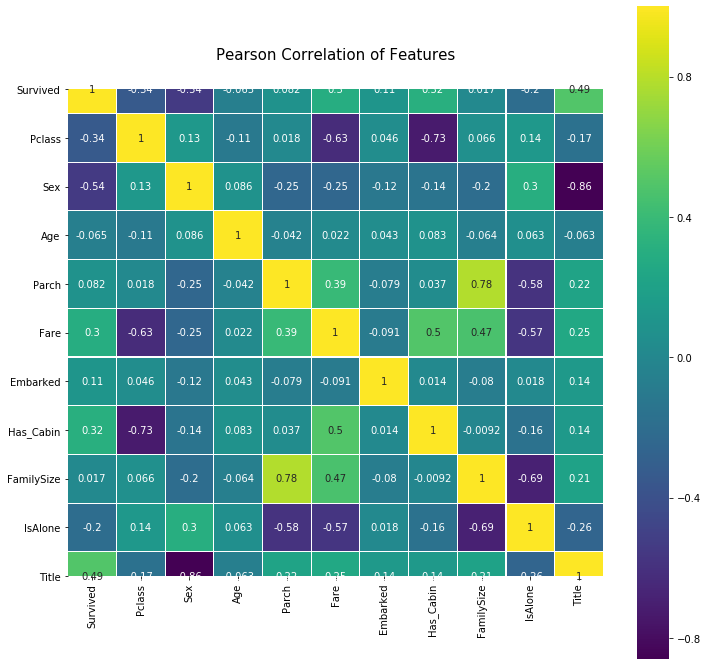

In [27]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

Observation:
1) Sex and Title show the highest correlations (in absolute terms) with the class (Survived): 0.54 and 0.49 respectively.
2) But the absolute correlation between both is also very high (0.86, the highest in our dataset), so they are probably carrying the same information and using the two as inputs for the same model wouldn't be a good idea.
3) High chances are one of them will be used for the first node in our final decision tree, so let's first explore further these features and compare them.

In [23]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])
# Since "Survived" is a binary class (0 or 1), these metrics grouped by the Title feature represent:
    # MEAN: survival rate
    # COUNT: total observations
    # SUM: people survived

# title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5} 

Survived           
           mean count  sum
Title                     
1      0.156673   517   81
2      0.575000    40   23
3      0.793651   126  100
4      0.702703   185  130
5      0.347826    23    8

In [25]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])
# Since "Survived" is a binary class (0 or 1), these metrics grouped by the Title feature represent:
    # MEAN: survival rate
    # COUNT: total observations
    # SUM: people survived

# title_mapping = {"female":0,"male":1} 

Survived           
         mean count  sum
Sex                     
0    0.742038   314  233
1    0.188908   577  109

Observations: 
General male survive = 0.18
From male Mr survive = 0.15
The title feature giving more cler picture of the survival of the people.The title feature has the sex property inbuilt

In [26]:
# Let's use our 'original_train' dataframe to check the sex distribution for each title.
# We use copy() again to prevent modifications in out original_train dataset
title_and_sex = original_train.copy()[['Name', 'Sex']]

# Create 'Title' feature
title_and_sex['Title'] = title_and_sex['Name'].apply(get_title)

# Map 'Sex' as binary feature
title_and_sex['Sex'] = title_and_sex['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

# Table with 'Sex' distribution grouped by 'Title'
title_and_sex[['Title', 'Sex']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

# Since Sex is a binary feature, this metrics grouped by the Title feature represent:
    # MEAN: percentage of men
    # COUNT: total observations
    # SUM: number of men

Sex           
              mean count  sum
Title                        
Capt      1.000000     1    1
Col       1.000000     2    2
Countess  0.000000     1    0
Don       1.000000     1    1
Dr        0.857143     7    6
Jonkheer  1.000000     1    1
Lady      0.000000     1    0
Major     1.000000     2    2
Master    1.000000    40   40
Miss      0.000000   182    0
Mlle      0.000000     2    0
Mme       0.000000     1    0
Mr        1.000000   517  517
Mrs       0.000000   125    0
Ms        0.000000     1    0
Rev       1.000000     6    6
Sir       1.000000     1    1

Observations:
We find that, excepting for a single observation (a female with 'Dr' title), all the observations for a given Title share the same Sex. 

Therefore the feature Title is capturing all the information present in Sex. In addition, Title may be more valuable to our task by capturing other characteristics of the individuals like age, social class, personality, ...

Even if the correlation of the feature Sex with the class Survived was higher, Title is a richer feature because it carries the Sex information but also adds other characteristics.Title is our first final model feature.

### Gini Impurity

In [28]:
#The DT will decidethe node split based on the Gini impurity.Lesser the Gine best is the split
#Gini Impurity can be explained as its the probability of mislebeling an element assuming that element is randomly lebelled according to the distribution of all the claases in the set

# Define function to calculate Gini Impurity
def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    random_observation_survived_prob = survival_prob
    random_observation_not_survived_prob = (1 - random_observation_survived_prob)
    mislabelling_survided_prob = not_survival_prob * random_observation_survived_prob
    mislabelling_not_survided_prob = survival_prob * random_observation_not_survived_prob
    gini_impurity = mislabelling_survided_prob + mislabelling_not_survided_prob
    return gini_impurity

In [29]:
# Gini Impurity of starting node
#First, we need to calculate the Gini Impurity of the starting node including all 891 observations in our train dataset. 
#Since only 342 observations survived, the survival probability is around 38,38% (342/891).

gini_impurity_starting_node = get_gini_impurity(342, 891)
gini_impurity_starting_node

0.47301295786144265

If we split by Sex, we'll have the two following nodes:

Node with men: 577 observations with only 109 survived
Node with women: 314 observations with 233 survived

In [30]:
# Gini Impurity decrease of node for 'male' observations
gini_impurity_men = get_gini_impurity(109, 577)
gini_impurity_men

0.3064437162277843

In [31]:
# Gini Impurity decrease if node splited for 'female' observations
gini_impurity_women = get_gini_impurity(233, 314)
gini_impurity_women

0.3828350034484158

In [32]:
# Gini Impurity decrease if node splited by Sex
men_weight = 577/891
women_weight = 314/891
weighted_gini_impurity_sex_split = (gini_impurity_men * men_weight) + (gini_impurity_women * women_weight)

sex_gini_decrease = weighted_gini_impurity_sex_split - gini_impurity_starting_node
sex_gini_decrease

-0.13964795747285214

If we split by Title == 1 (== Mr), we'll have the two following nodes:

Node with only Mr: 517 observations with only 81 survived
Node with other titles: 374 observations with 261 survived

In [33]:
# Gini Impurity decrease of node for observations with Title == 1 == Mr
gini_impurity_title_1 = get_gini_impurity(81, 517)
gini_impurity_title_1

0.26425329886377663

In [34]:
# Gini Impurity decrease if node splited for observations with Title != 1 != Mr
gini_impurity_title_others = get_gini_impurity(261, 374)
gini_impurity_title_others

0.42170207898424317

In [35]:
# Gini Impurity decrease if node splited for observations with Title == 1 == Mr
title_1_weight = 517/891
title_others_weight = 374/891
weighted_gini_impurity_title_split = (gini_impurity_title_1 * title_1_weight) + (gini_impurity_title_others * title_others_weight)

title_gini_decrease = weighted_gini_impurity_title_split - gini_impurity_starting_node
title_gini_decrease

-0.14267004758907514

Observations:
We find that the Title feature is slightly better at reducing the Gini Impurity than Sex. This confirms our previous analysis, and we're now sure that Title will be used for the first split. Sex will therefore be neglected since the information is already included in the Title feature.

### Finding best tree depth with the help of Cross Validation

In [36]:
cv = KFold(n_splits=10)            # Desired number of Cross Validation folds
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

# Testing max_depths from 1 to max attributes
# Uncomment prints for details about each Cross Validation pass
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold] # Extract train data with cv indices
        f_valid = train.loc[valid_fold] # Extract valid data with cv indices

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) # We fit the model with the fold train data
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])# We calculate accuracy with the fold validation data
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    print("Accuracy per fold: ", fold_accuracy, "\n")
    print("Average accuracy: ", avg)
    print("\n")
    
# Just to show results conveniently
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

Current max depth:  1 

Accuracy per fold:  [0.7666666666666667, 0.7752808988764045, 0.7528089887640449, 0.8539325842696629, 0.7640449438202247, 0.8089887640449438, 0.7528089887640449, 0.7528089887640449, 0.8426966292134831, 0.7528089887640449] 

Average accuracy:  0.7822846441947565


Current max depth:  2 

Accuracy per fold:  [0.7222222222222222, 0.8202247191011236, 0.7640449438202247, 0.8426966292134831, 0.797752808988764, 0.8314606741573034, 0.797752808988764, 0.7640449438202247, 0.8539325842696629, 0.797752808988764] 

Average accuracy:  0.7991885143570537


Current max depth:  3 

Accuracy per fold:  [0.8333333333333334, 0.8764044943820225, 0.7640449438202247, 0.8651685393258427, 0.8202247191011236, 0.8202247191011236, 0.7865168539325843, 0.7865168539325843, 0.8764044943820225, 0.8539325842696629] 

Average accuracy:  0.8282771535580522


Current max depth:  4 

Accuracy per fold:  [0.8333333333333334, 0.8089887640449438, 0.7865168539325843, 0.797752808988764, 0.8202247191011236

Observations:
The best max_depth parameter seems therefore to be 3 (82.8% average accuracy across the 10 folds), and feeding the model with more data results in worst results probably due to over-fitting. We'll therefore use 3 as the max_depth parameter for our final model.

### Final Tree

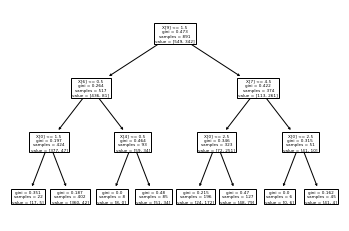

In [57]:
# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
y_train = train['Survived']
x_train = train.drop(['Survived'], axis=1).values 
x_test = test.values

# Create Decision Tree with max_depth = 3
decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x_train, y_train)

# Predicting results for test dataset
y_pred = decision_tree.predict(x_test)
submission = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": y_pred
    })
submission.to_csv('submission.csv', index=False)

tree.plot_tree(decision_tree);

In [58]:

# Export our trained model as a .dot file
with open("tree.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = list(train.drop(['Survived'], axis=1)),
                              class_names = ['Died', 'Survived'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
#check_call(['dot','-Tpng','E:/VSCODE/GIT_Hub/myML/Kaggle/tree1.dot','-o','E:/VSCODE/GIT_Hub/myML/Kaggle/tree1.png'])
#check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

!dot -Tpng tree.dot -o tree.png


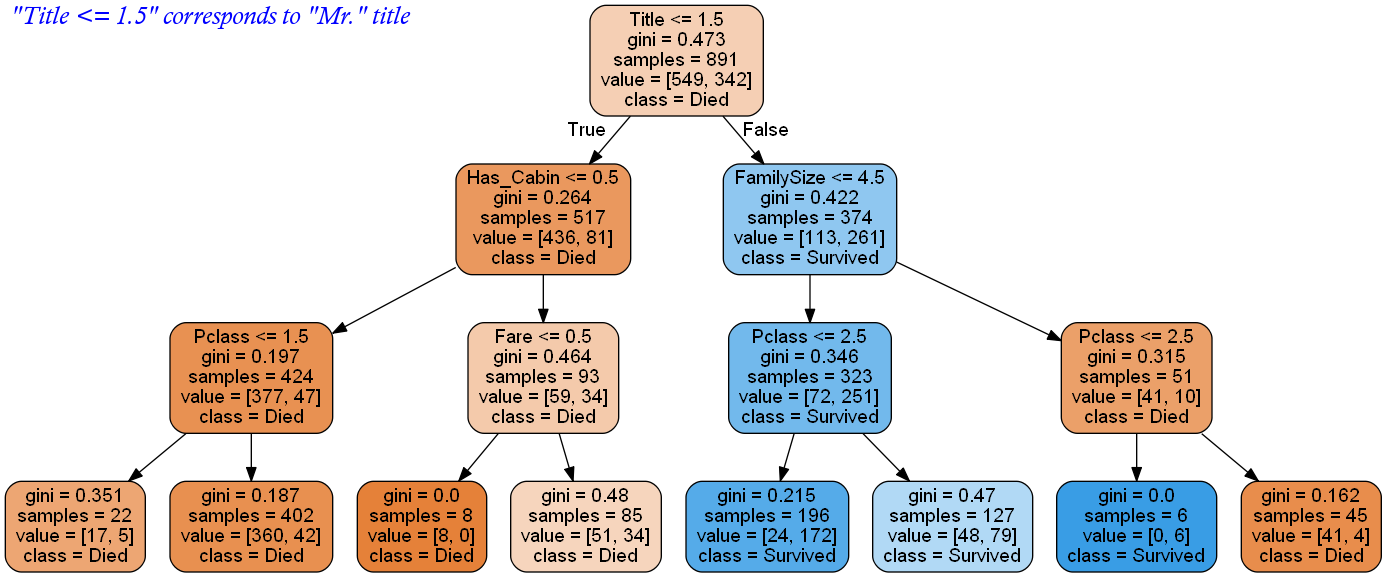

In [61]:
# Annotating chart with PIL
img = Image.open("tree.png")
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('C:\\Windows\\Fonts\\CALISTI.TTF', 26)
draw.text((10, 0), # Drawing offset (position)
          '"Title <= 1.5" corresponds to "Mr." title', # Text to draw
          (0,0,255), # RGB desired color
          font=font) # ImageFont object with desired font
img.save('sample-out.png')
PImage("sample-out.png")

In [60]:
# Code to check available fonts and respective paths
#import matplotlib.font_manager
#matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

['C:\\Windows\\Fonts\\CALISTI.TTF',
 'C:\\Windows\\Fonts\\consolaz.ttf',
 'C:\\Windows\\Fonts\\GOTHICI.TTF',
 'C:\\Windows\\Fonts\\PERBI___.TTF',
 'C:\\WINDOWS\\Fonts\\PAPYRUS.TTF',
 'C:\\WINDOWS\\Fonts\\LTYPEBO.TTF',
 'C:\\WINDOWS\\Fonts\\ROCC____.TTF',
 'C:\\Windows\\Fonts\\LCALLIG.TTF',
 'C:\\WINDOWS\\Fonts\\pala.ttf',
 'C:\\WINDOWS\\Fonts\\CENSCBK.TTF',
 'C:\\Windows\\Fonts\\BKANT.TTF',
 'C:\\WINDOWS\\Fonts\\timesbi.ttf',
 'C:\\Windows\\Fonts\\simsun.ttc',
 'C:\\Windows\\Fonts\\Candarai.ttf',
 'C:\\WINDOWS\\Fonts\\AGENCYR.TTF',
 'C:\\Windows\\Fonts\\ARIALNI.TTF',
 'C:\\Windows\\Fonts\\mmrtextb.ttf',
 'C:\\WINDOWS\\Fonts\\OUTLOOK.TTF',
 'C:\\Windows\\Fonts\\msjhl.ttc',
 'C:\\Windows\\Fonts\\consolab.ttf',
 'C:\\WINDOWS\\Fonts\\BOOKOSI.TTF',
 'C:\\WINDOWS\\Fonts\\Candara.ttf',
 'C:\\WINDOWS\\Fonts\\HARLOWSI.TTF',
 'C:\\Windows\\Fonts\\BRADHITC.TTF',
 'C:\\WINDOWS\\Fonts\\verdanai.ttf',
 'C:\\Windows\\Fonts\\STENCIL.TTF',
 'C:\\WINDOWS\\Fonts\\holomdl2.ttf',
 'C:\\Windows\\Fonts\\taho

In [39]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
acc_decision_tree

82.38

Conclusions:
We can note that smaller families had better chances to survive, maybe because bigger families tried to stick together or look for missing members and therefore didn't had places left in the lifeboats. Finally, we can observe that 3rd class passengers had also less chances to survive so probably passengers belonging to upper social social classes were privileged, or simply 3rd class cabins may have been further away of the lifeboats.